In [2]:
import time
import pathlib

import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [3]:
df = (pd.read_csv("outofscope-intent-classification-dataset.csv")
      .loc[lambda d: ~d['text'].isna()]
      .loc[lambda d: ~d['label'].isna()])

def assign_bad_label(dataf, percentage=0.05):
    """Method to flip a label in a dataframe."""
    random_label = np.random.choice(df['label'], size=df['label'].shape)
    predicate = np.random.uniform(size=df['label'].shape) < percentage
    return (dataf
            .copy()
            .assign(err_label=lambda d: np.where(predicate, random_label, d['label'])))

def flip_label(label_col, percentage=0.05):
    """Method to flip a label in a numpy array."""
    random_label = np.random.choice(label_col, size=label_col.shape)
    predicate = np.random.uniform(size=label_col.shape) < percentage
    return np.where(predicate, random_label, label_col)

In [4]:
%%time

# Generate a train/test split
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'],
                                                test_size=0.50,
                                                stratify=df['label'],
                                                random_state=42)

# Construct a simple (and fast) pipeline
mod = make_pipeline(CountVectorizer(),
                    LogisticRegression(solver='liblinear', class_weight='balanced'))

# Flip some of the labels
p_train, p_test = 0.15, 0.01
y_train_flip = flip_label(y_train, percentage=p_train)
y_test_flip = flip_label(y_test, percentage=p_test)

# Fit the model
mod.fit(X_train, y_train_flip)

# Measure the impact on the summary stats
reported_acc_train = np.mean(mod.predict(X_train) == y_train_flip)
actual_acc_train = np.mean(mod.predict(X_train) == y_train)
reported_acc_test = np.mean(mod.predict(X_test) == y_test_flip)
actual_acc_test = np.mean(mod.predict(X_test) == y_test)

CPU times: user 4.65 s, sys: 26.1 ms, total: 4.68 s
Wall time: 4.68 s


In [5]:
print(f"Train Score Reported: {np.round(reported_acc_train, 4)}/{np.round(actual_acc_train, 4)}")
print(f" Test Score Reported: {np.round(reported_acc_test, 4)}/{np.round(actual_acc_test, 4)}")

Train Score Reported: 0.8363/0.9417
 Test Score Reported: 0.862/0.8692


## Let's Dive! 

The dataset that I'm using here is relatively easy. But there's an interesting effect happening here.

In [22]:
from memo import memlist, grid 

data = []

@memlist(data=data)
def benchmark(p_train, p_test):
    # Generate a train/test split
    X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'],
                                                    test_size=0.50,
                                                    stratify=df['label'],
                                                    random_state=42)

    # Construct a simple (and fast) pipeline
    mod = make_pipeline(CountVectorizer(),
                        LogisticRegression(solver='liblinear', class_weight='balanced'))

    # Flip some of the labels
    y_train_flip = flip_label(y_train, percentage=p_train)
    y_test_flip = flip_label(y_test, percentage=p_test)

    # Fit the model
    mod.fit(X_train, y_train_flip)

    # Measure the impact on the summary stats
    reported_acc_train = np.mean(mod.predict(X_train) == y_train_flip)
    actual_acc_train = np.mean(mod.predict(X_train) == y_train)
    reported_acc_test = np.mean(mod.predict(X_test) == y_test_flip)
    actual_acc_test = np.mean(mod.predict(X_test) == y_test)
    return {
        "reported_acc_train": reported_acc_train,
        "actual_acc_train": actual_acc_train,
        "reported_acc_test": reported_acc_test,
        "actual_acc_test": actual_acc_test
    }

settings = grid(p_train=np.linspace(0, 0.9, 20), p_test=np.linspace(0, 0.3, 5))

In [23]:
from memo import Runner

runner = Runner(backend="threading", n_jobs=8)
runner.run(benchmark, settings)

In [24]:
pltr = pd.DataFrame(data)

In [31]:
import altair as alt

p1 = (alt.Chart(pltr)
  .mark_line()
  .encode(x='p_train', y='reported_acc_test', color=alt.Color('p_test'))
  .properties(width=300, height=250, title="reported accuracy")
  .interactive())

p2 = (alt.Chart(pltr)
  .mark_line()
  .encode(x='p_train', y='actual_acc_test', color=alt.Color('p_test'))
  .properties(width=300, height=250, title="actual accuracy")
  .interactive())

p1 | p2

alt.HConcatChart(...)

We can add a lot of noise without seeing it affect the actual test set prediction. The downside however is that this is not what we might measure, we measure the **reported** accuracy.

## Use-Case in Real Life

In reality we likely won't worry about 40% label errors, but a 1% label errors in the test set can still be horrible when we're doing hyperparameter tuning. So let's see if we can find the wrongly labelled datapoints if we compare the model output with the dataset.

In [6]:
from IPython.core.display import HTML

setting = "train"

if setting == "train":
    dataf = pd.DataFrame({"text": X_train, "label": y_train, "flip_label": y_train_flip})
if setting == "test":
    dataf = pd.DataFrame({"text": X_test, "label": y_test, "flip_label": y_test_flip})

score_tbl = (dataf
 .assign(pred=lambda d: mod.predict(d['text']))
 .assign(score=lambda d: np.max(mod.predict_proba(d['text']), axis=1))
 .sort_values("score"))

HTML(score_tbl.loc[lambda d: d['flip_label'] != d['pred']].tail(5).to_html())

,text,label,flip_label,pred,score
17548,what do i need to do in order to redeem my credit card points,redeem_rewards,are_you_a_bot,redeem_rewards,0.817966
10867,please let my bank know that i will be in uruguay from january to august,travel_notification,what_are_your_hobbies,travel_notification,0.833862
5860,how long will it take for me to get a new credit card to replace the one that was stolen,replacement_card_duration,oos,replacement_card_duration,0.834496
10821,please let my bank know that i will be in rome from february 1 to march 1,travel_notification,recipe,travel_notification,0.838342
14055,"how do i change my pin number for my account, please",pin_change,sync_device,pin_change,0.859253


In [60]:
from memo import memlist 
from sklearn.metrics import precision_score, recall_score 

data = []

@memlist(data=data)
def calc_curves(threshold=0.1):
    """Calculate the precision/recall curves."""
    pred_tbl = (score_tbl
         .assign(detection=lambda d: d['flip_label'] != d['pred'])
         .assign(detection=lambda d: d['detection'] & (d['score'] > threshold))
         .assign(truth=lambda d: d['flip_label'] != d['label']))
    return {
        'precision': precision_score(pred_tbl['truth'], pred_tbl['detection']),
        'recall': recall_score(pred_tbl['truth'], pred_tbl['detection']),
        'n': pred_tbl['detection'].sum()
    }


for t in np.linspace(0.05, 0.85, 50):
    calc_curves(threshold=t)
    
pltr = pd.DataFrame(data).loc[lambda d: d['n'] > 0]

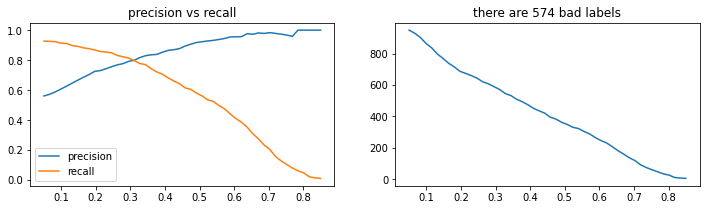

In [61]:
import matplotlib.pylab as plt

pltr = pd.DataFrame(data)

plt.figure(figsize=(12, 3))
plt.subplot(121)
plt.plot(pltr['threshold'], pltr['precision'], label="precision")
plt.plot(pltr['threshold'], pltr['recall'], label="recall")
plt.title(f"precision vs recall");
plt.legend()
plt.subplot(122)
plt.plot(pltr['threshold'], pltr['n'], label="precision")
plt.title(f"there are {(score_tbl['flip_label'] != score_tbl['label']).sum()} bad labels");

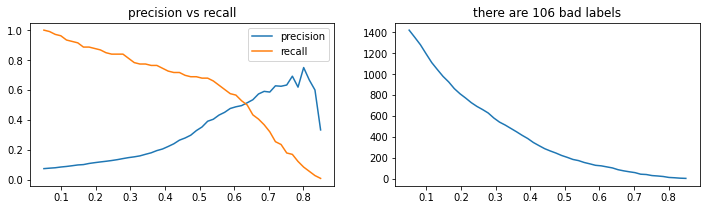

In [33]:
import matplotlib.pylab as plt

pltr = pd.DataFrame(data)

plt.figure(figsize=(12, 3))
plt.subplot(121)
plt.plot(pltr['threshold'], pltr['precision'], label="precision")
plt.plot(pltr['threshold'], pltr['recall'], label="recall")
plt.title(f"precision vs recall");
plt.legend()
plt.subplot(122)
plt.plot(pltr['threshold'], pltr['n'], label="precision")
plt.title(f"there are {(score_tbl['flip_label'] != score_tbl['label']).sum()} bad labels");